In [44]:
options(warn=-1)

library(xts)
library(Quandl)
library(dplyr)
library(plotly)
library(lubridate)
library(forecast)
library(TSPred)
library(fGarch)
library(tseries)

### Dowload data using Quandl API

- The API will provide weekly data since 04/08/1990 
- It will form a dataframe which needs to be reversed to in chronological order

In [45]:
qurtly_data = Quandl("CHRIS/CME_CL1", collapse = 'quarterly')
monthly_data = Quandl("CHRIS/CME_CL1", collapse = 'monthly')
weekly_data = Quandl("CHRIS/CME_CL1", collapse = 'weekly')
daily_data = Quandl("CHRIS/CME_CL1", collapse = 'daily')

In [46]:
qurtly_data <- qurtly_data[rev(rownames(qurtly_data)),]
monthly_data <- monthly_data[rev(rownames(monthly_data)),]
weekly_data <- weekly_data[rev(rownames(weekly_data)),]
daily_data <- daily_data[rev(rownames(daily_data)),]

In [47]:
head(weekly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
1788,1983-04-03,29.40,29.60,29.25,29.29,NA,29.29,521,523
1787,1983-04-10,30.65,30.65,30.25,30.38,NA,30.38,365,651
1786,1983-04-17,30.55,30.60,30.35,30.48,NA,30.48,295,908
1785,1983-04-24,30.62,30.85,30.62,30.75,NA,30.75,307,1075
1784,1983-05-01,30.70,30.74,30.63,30.63,NA,30.63,323,927
1783,1983-05-08,30.18,30.45,30.18,30.45,NA,30.45,248,634


In [48]:
tail(weekly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
6,2017-05-28,48.75,49.94,48.18,49.87,0.90,49.80,759936,578141
5,2017-06-04,48.04,48.19,46.74,47.74,0.70,47.66,798917,551317
4,2017-06-11,45.71,46.18,45.27,45.90,0.19,45.83,712341,399576
3,2017-06-18,44.25,44.94,44.24,44.68,0.28,44.74,187501,104865
2,2017-06-25,42.80,43.20,42.53,43.17,0.27,43.01,689563,535511
1,2017-07-02,43.70,44.90,43.67,44.88,0.50,44.74,750997,541143


In [49]:
dim(qurtly_data)
dim(monthly_data)
dim(weekly_data)
dim(daily_data)

[1] 138   9

[1] 412   9

[1] 1788    9

[1] 8605    9

In [134]:
p1 <- plot_ly(daily_data, x = ~Date, y = ~Open, type = 'scatter', mode = 'lines') %>%
        layout(title = "Natural Gas Prices Chart",
         xaxis = list(title = "Year"),
         yaxis = list (title = "Price in US$ per Million BTU"))
p1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Convert the dataframe into a time series and check properties

In [50]:
#qurtly_ts <- ts(qurtly_data$Open, frequency=4, start = decimal_date(ymd("1990-06-30")))
#monthly_ts <- ts(log(monthly_data$Open))
#daily_ts <- ts(daily_data$Open)

weekly_ts <- ts(weekly_data$Open, frequency=52, start = decimal_date(ymd("1983-04-03")))

#gas_ts <- ts(log(gas_data$Open), frequency=12, start=decimal_date(ymd("1990-04-30")))

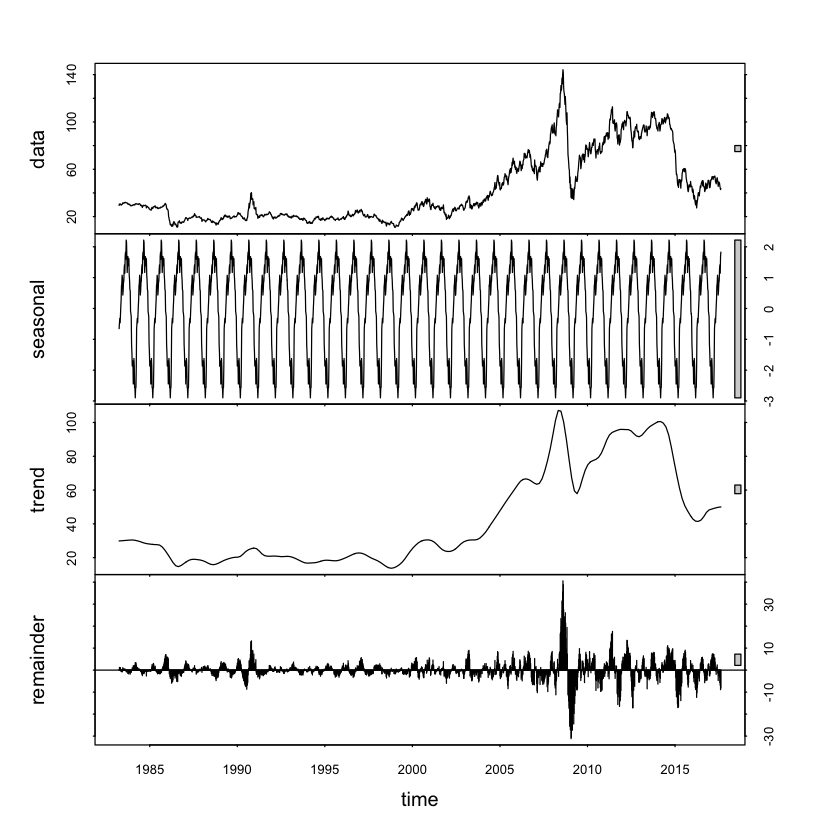

In [51]:
# Decompose time series

decomp = stl(weekly_ts, s.window="periodic")
plot(decomp)

We clearely see seasonality in the residual plot. For Time Series analysis, we need to convert it into a stationary series.

The ***augmented Dickey-Fuller (ADF)*** test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

In [15]:
adf.test(weekly_ts, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  weekly_ts
Dickey-Fuller = -3.2111, Lag order = 12, p-value = 0.086
alternative hypothesis: stationary


This means that the series is not stationary. Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. 


	Augmented Dickey-Fuller Test

data:  weekly_dff1
Dickey-Fuller = -10.162, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary


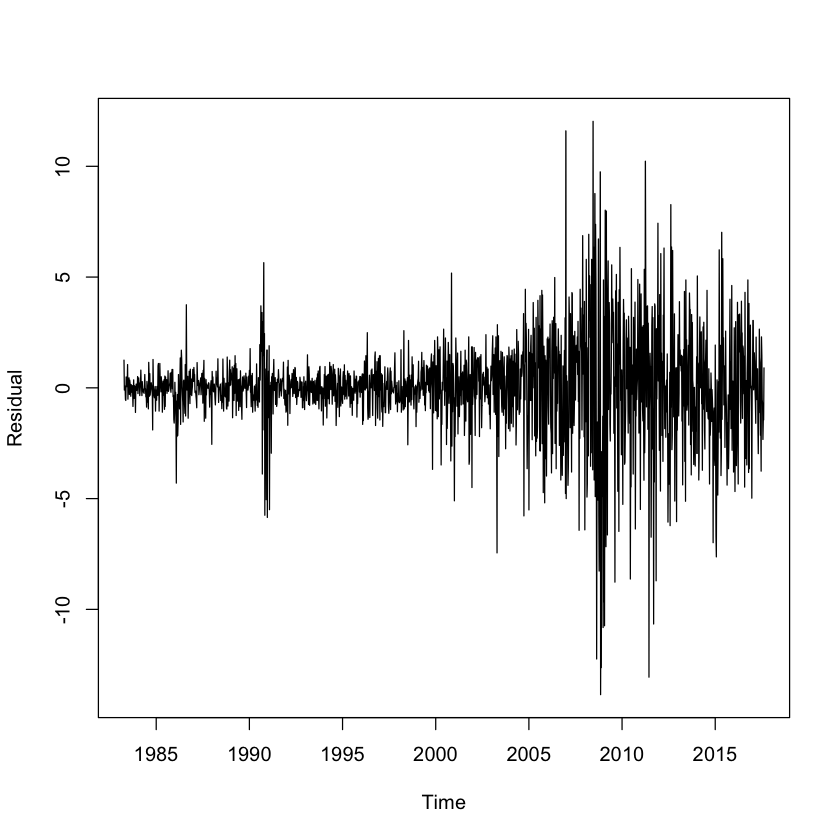

In [23]:
weekly_dff1 = diff(weekly_ts, differences = 1)
adf.test(weekly_dff1, alternative = "stationary")

plot(weekly_dff1, ylab="Residual")

In [24]:
summary(weekly_dff1)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-13.850000  -0.750000   0.030000   0.008002   0.850000  12.030000 

The mean is close to 0 and Dickey-Fuller Test suggests that the null hypothesis can be rejected. That is TS is close to being a stationary and differencing parameter ***d = 1***

*** Autocorrelations and Choosing Model Order ***

Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model. Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

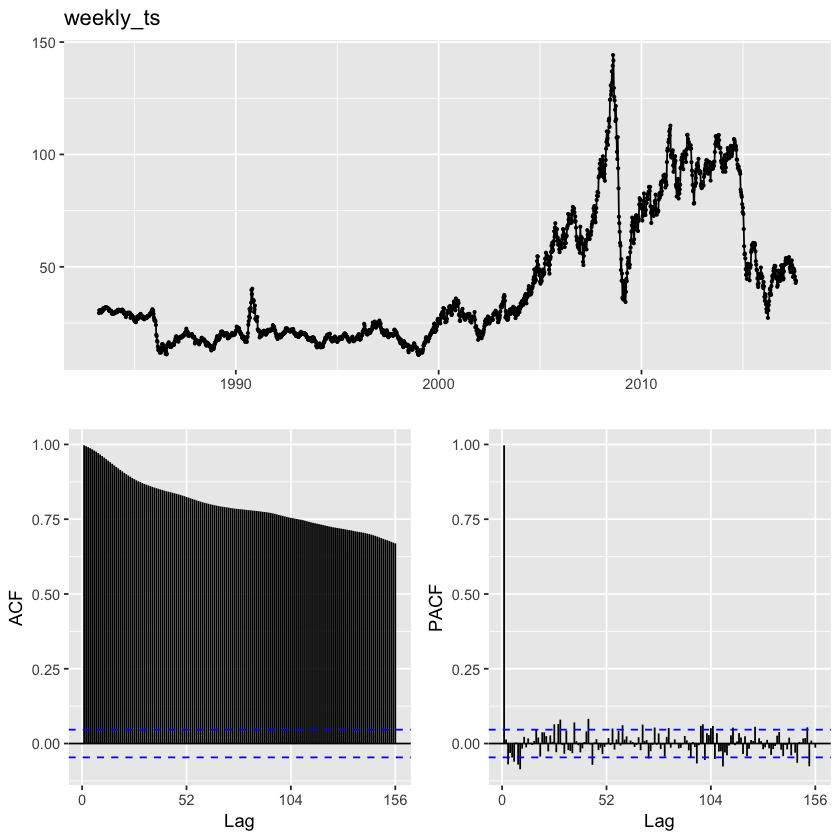

In [18]:
# Inspect ACF and PACF

ggtsdisplay(weekly_ts)

#### Auto-correlation of residual

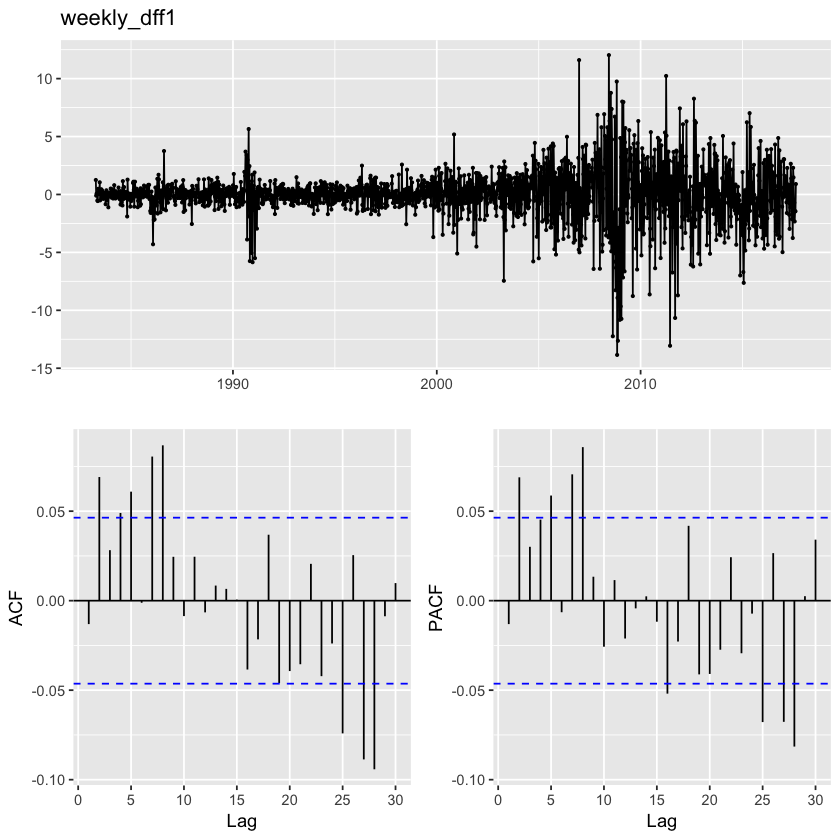

In [26]:
ggtsdisplay(weekly_dff1, lag.max = 30)

There are significant auto correlations at lag 8 and 11 and beyond. Partial correlation plots show a significant spike at lag 3 and 9. This suggests that we might want to test models with AR or MA components of order 2, 8, or 11.


Call:
arima(x = weekly_ts, order = c(8, 1, 8))

Coefficients:
          ar1     ar2     ar3     ar4     ar5     ar6      ar7      ar8     ma1
      -0.0887  0.3463  0.2132  0.6272  0.1095  0.3898  -0.1264  -0.7848  0.0844
s.e.      NaN  0.0391  0.0806  0.0392  0.0442  0.0487   0.0248   0.0591     NaN
          ma2      ma3      ma4      ma5      ma6     ma7     ma8
      -0.2829  -0.1723  -0.6127  -0.0998  -0.4541  0.1382  0.7946
s.e.   0.0356   0.0599   0.0414   0.0383   0.0422  0.0146  0.0560

sigma^2 estimated as 4.659:  log likelihood = -3911.21,  aic = 7856.41

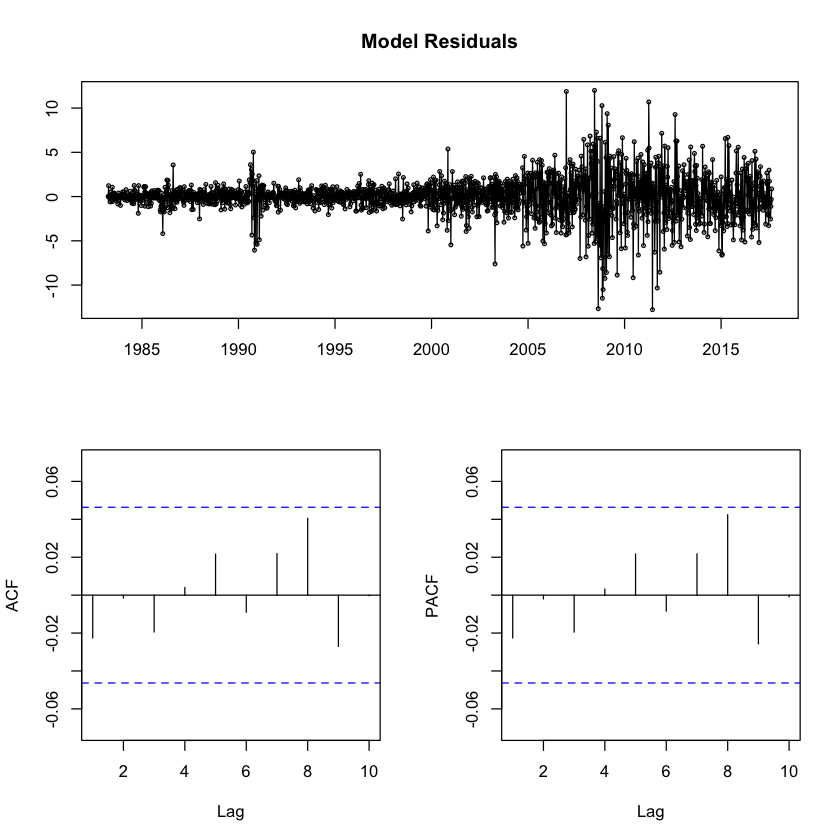

In [27]:
fit_weekly = arima(weekly_ts, order=c(8,1,8))
fit_weekly

tsdisplay(residuals(fit_weekly), lag.max=10, main='Model Residuals')

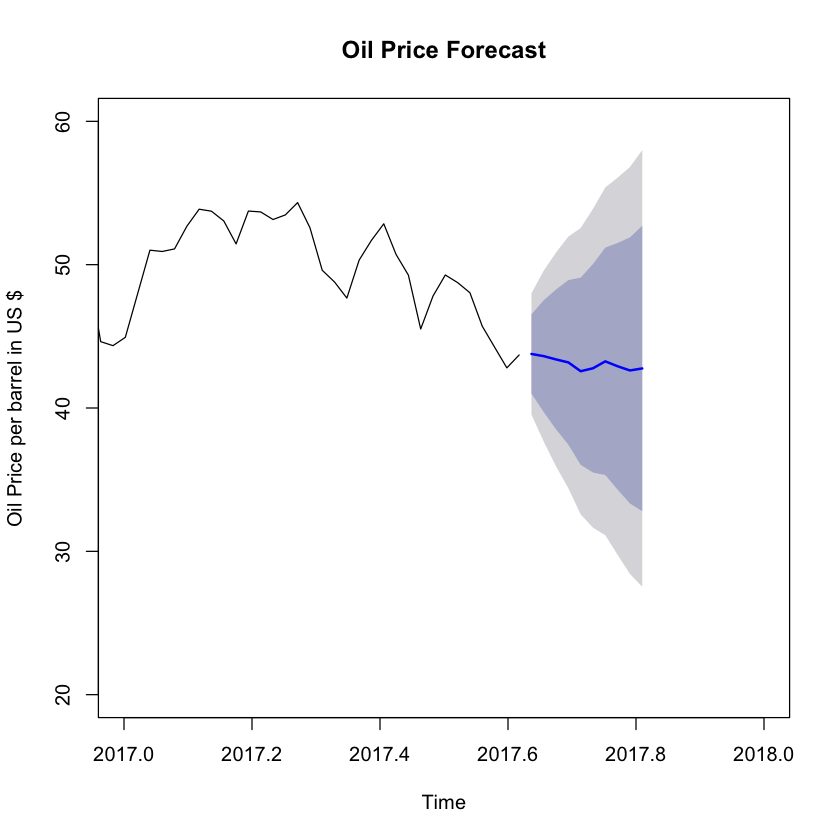

In [58]:
fcast_weekly <- forecast(fit_weekly, h=10)
plot(fcast_weekly, xlim = c(2017,2018), ylim = c(20,60), xlab = "Time", ylab = "Oil Price per barrel in US $", 
    main = "Oil Price Forecast")

In [29]:
fcast_weekly

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2017.637       43.77005 41.00386 46.53624 39.53952 48.00057
2017.656       43.61747 39.71391 47.52103 37.64749 49.58745
2017.675       43.38720 38.50599 48.26841 35.92203 50.85237
2017.694       43.18007 37.43808 48.92207 34.39845 51.96170
2017.714       42.56583 36.03358 49.09809 32.57561 52.55606
2017.733       42.77176 35.49972 50.04380 31.65013 53.89339
2017.752       43.25477 35.32146 51.18807 31.12182 55.38771
2017.771       42.91162 34.30919 51.51405 29.75534 56.06790
2017.791       42.61983 33.33806 51.90160 28.42458 56.81508
2017.810       42.75991 32.80288 52.71694 27.53194 57.98787

# Exponential Smoothing

In [34]:
exp_model <- HoltWinters(weekly_ts)

exp_model

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = weekly_ts)

Smoothing parameters:
 alpha: 0.9814051
 beta : 0
 gamma: 0.8363582

Coefficients:
           [,1]
a   43.57787382
b   -0.03915462
s1  -0.11194388
s2   0.76311018
s3   0.48641489
s4   0.24720161
s5   0.27692165
s6   0.84008073
s7   0.46236746
s8  -0.02809920
s9  -0.01133594
s10 -0.03434834
s11 -0.42512807
s12 -0.26008129
s13 -0.32811009
s14 -0.91775062
s15 -1.55125169
s16 -1.39495535
s17 -1.36552871
s18 -1.79479825
s19 -1.60379711
s20 -1.27239166
s21 -1.02231470
s22 -0.96879758
s23 -0.99848269
s24 -0.28625094
s25  0.13334427
s26 -0.30484809
s27 -0.65908509
s28 -0.24546583
s29  0.19849891
s30  0.79946704
s31  0.91792167
s32  1.07165533
s33  1.46026398
s34  1.04659612
s35  0.98062009
s36  0.71094564
s37  0.82155043
s38  0.72229044
s39  0.68435201
s40  1.19480567
s41  1.28624922
s42  1.36527377
s43  0.98965181
s44  0.48619881
s45  0.20531135
s46  0.20058064
s47  0.20844603
s48

In [35]:
exp_pred <- predict(exp_model, 5, prediction.interval = TRUE)
exp_pred

fit,upr,lwr
43.42678,47.84638,39.00717
44.26267,50.45510,38.07025
43.94682,51.50720,36.38645
43.66846,52.38468,34.95223
43.65902,53.39482,33.92322


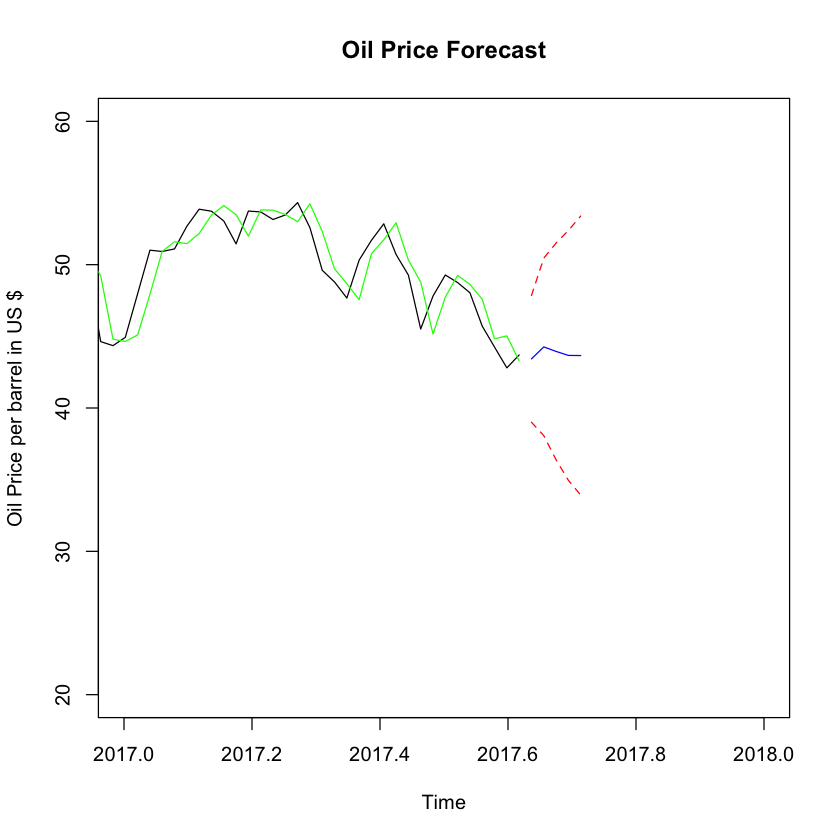

In [59]:
plot.ts(weekly_ts,xlim = c(2017, 2018), ylim = c(20, 60), xlab = "Time", ylab = "Oil Price per barrel in US $",
       main = "Oil Price Forecast")
lines(exp_model$fitted[,1], col = "green")
lines(exp_pred[,1], col = "blue")
lines(exp_pred[,2], col = "red", lty = 2)
lines(exp_pred[,3], col = "red", lty = 2)

***Conclusion***: The predicted WTI Oil next week price is \$ 43.7 per barrel with 80% confidence interval of \$ (41.0 - 46.5). 